In [89]:
from fastai.vision.all import *

In [8]:
ls -al data/train/

total 1800
drwxr-xr-x 4 root root     44 May  8 12:37 ./
drwxr-xr-x 6 root root    135 May  9 01:42 ../
drwxr-xr-x 2 root root 782336 May  9 01:49 images/
drwxr-xr-x 2 root root 782336 May  9 01:49 mask/


In [90]:
data_path = Path('data/')

In [91]:
data_path.ls()

(#5) [Path('data/dicom-images-test'),Path('data/dicom-images-train'),Path('data/pneumothorax'),Path('data/train-rle.csv'),Path('data/train')]

In [102]:
size=512
bs=64

In [103]:
db = DataBlock(blocks=(ImageBlock(),MaskBlock()),
               item_tfms=[Resize(size)],
               get_items=get_image_files,get_y=lambda o:str(o).replace('images','mask'))

In [104]:
dls = db.dataloaders(source=data_path/'train'/'images',bs=bs)

In [105]:
[i for i,o in enumerate(dls.dataset[:40]) if np.array(o[1]).sum() >0]

[10, 25, 29, 36, 38]

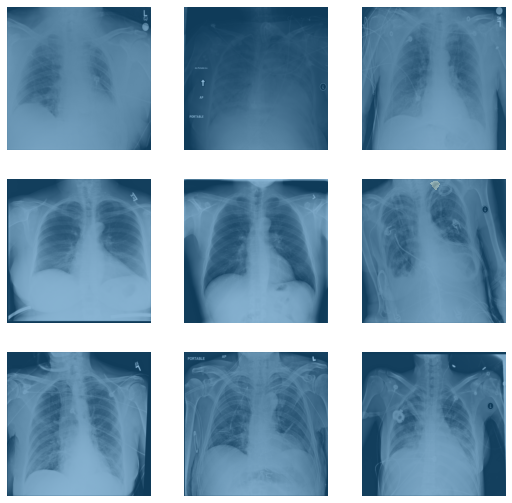

In [108]:
dls.show_batch()

In [109]:
trn_images_path = (data_path/'train/images')
trn_masks_path = (data_path/'train/mask')

In [110]:
data_path

Path('data')

In [111]:
idx = 8141
img = Image.open(trn_images_path.ls()[idx])
msk = Image.open(trn_masks_path.ls()[idx])

In [112]:
def plt_img_mask(img,msk):
    plt.imshow(img,cmap='gray')
    plt.imshow(msk,cmap='jet',alpha=0.3)

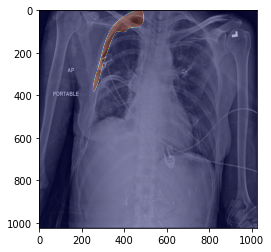

In [114]:
plt_img_mask(img,msk)